# Gridworld

In [28]:
import gym 
import gym_examples

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 


env = gym.make('gym_examples/GridWorld-v0', size=10)

env.reset()
done = False
i = 0
while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    i += 1
    
print(i)

240


### Sarsa

In [29]:
np.random.seed(123)

def epsilon_greedy(obs, Q, epsilon=0.9):
    
    # Agents location
    loc = obs['agent']
    # Retrieve Q-values
    qs = Q[loc[0], loc[1]]
    
    if np.random.uniform(0, 1) < epsilon: 
        action = env.action_space.sample()
    else:
        # Best action
        action = np.argmax(qs)
        
    return action 
    
# Some parameters 
grid_size = 10
num_episodes = 1000
alpha = 0.01 # Learning rate
gamma = 0.95 # Discount factor
e_max = 0.99 # Max epsilon
e_min = 0.0 # Minimum epsilon

env = gym.make('gym_examples/GridWorld-v0', size=grid_size)

# Initialise Q-values: 3D array 
Q = np.zeros((env.size, env.size, env.action_space.n))

# Initialise ts 
ts_sarsa = np.zeros(num_episodes)

for i in range(num_episodes): 
    obs = env.reset()
    done = False
    t = 0 
    
    # Scheduling epsilon to decrease over time 
    epsilon = e_max - ((i+ 1) / num_episodes) * (e_max - e_min)
    
    # Get initial agent location and sample action
    loc = obs['agent']
    action = epsilon_greedy(obs, Q, epsilon)
    
    while not done: 
        t += 1
                
        # Step forward the environment, determining reward r 
        obs_next, reward, done, info = env.step(action)
        
        # Get agent's next-step location and sample aciton (s', a')
        loc_next = obs_next['agent']
        action_next = epsilon_greedy(obs_next, Q, epsilon)
                
        # Update Q-values using following Sarsa update:
        # Q(s,a) <- Q(s,a) + \alpha * [r + \gamma Q(s',a') - Q(s,a)]
        Q_old = Q[loc[0], loc[1], action]
        Q[loc[0], loc[1], action] = Q_old + alpha * (reward + gamma * Q[loc_next[0], loc_next[1], action_next] - Q_old)
        
        # Carry forward action, state, location to use in the next timestep
        action = action_next
        obs = obs_next
        loc = loc_next
        
    ts_sarsa[i] = t
        


Plotting results:

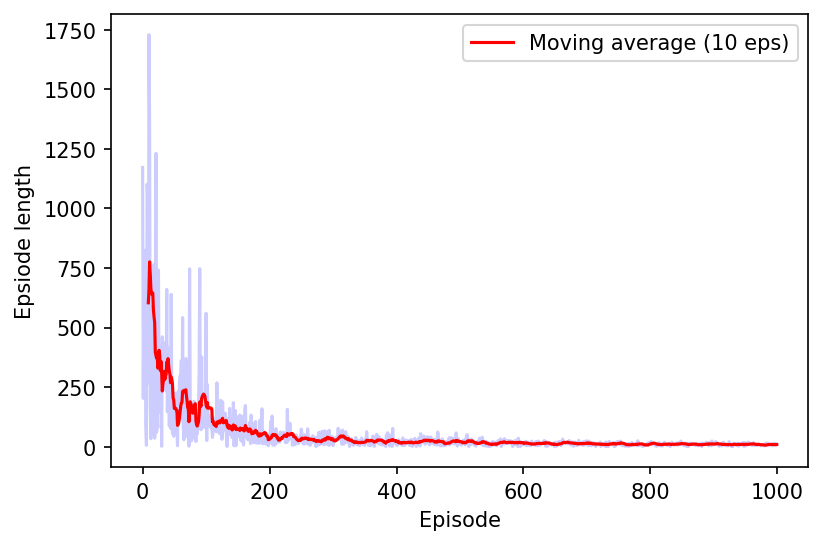

In [30]:
fig, ax = plt.subplots(dpi=150)

ma_sarsa = pd.Series(ts_sarsa).rolling(10).mean() # Moving average

ax.plot(ts_sarsa, alpha=0.2, c='b')
ax.plot(ma_sarsa, c='r', label='Moving average (10 eps)')
ax.set_xlabel('Episode')
ax.set_ylabel('Epsiode length')

plt.legend()


We can watch the trained agent (a bit dodgy on my machine!): 

In [31]:
run = False
if run: 

    obs = env.reset()
    done = False

    while not done: 
        t += 1
        action = epsilon_greedy(obs, Q, 0)
        obs, reward, done, info = env.step(action)
        env.render()

    env.close()


Look at the Q-values for the position [1,0] (the order of actions is [right, up, left, down]

In [32]:
Q[1,0]

array([0.15383402, 0.1596266 , 1.09500374, 0.47774399])

### Q-Learning

In [33]:
np.random.seed(123)

# Using previous parameters as before

env = gym.make('gym_examples/GridWorld-v0', size=grid_size)

# Initialise Q-values: 3D array 
Q = np.zeros((env.size, env.size, env.action_space.n))

# Initialise ts 
ts_q = np.zeros(num_episodes)

for i in range(num_episodes): 
    obs = env.reset()
    done = False
    t = 0 
    
    # Scheduling epsilon to decrease over time 
    epsilon = e_max - ((i+ 1) / num_episodes) * (e_max - e_min)
    
    while not done: 
        t += 1
        
        # Get initial agent location and sample action
        loc = obs['agent']
        action = epsilon_greedy(obs, Q, epsilon)
                
        # Step forward the environment, determining reward r 
        obs_next, reward, done, info = env.step(action)
        
        # Get agent's next-step location and sample aciton (s', a')
        loc_next = obs_next['agent']

        # Update Q-values using following Q-learning update:
        # Q(s,a) <- Q(s,a) + \alpha * [r + \gamma max_{a'} Q(s',a') - Q(s,a)]
        Q_old = Q[loc[0], loc[1], action]
        Q_best = np.max(Q[loc_next[0], loc_next[1]])
        Q[loc[0], loc[1], action] = Q_old + alpha * (reward + gamma * Q_best - Q_old)
        
        # Carry forward action, state, location to use in the next timestep
        obs = obs_next
        
    ts_q[i] = t

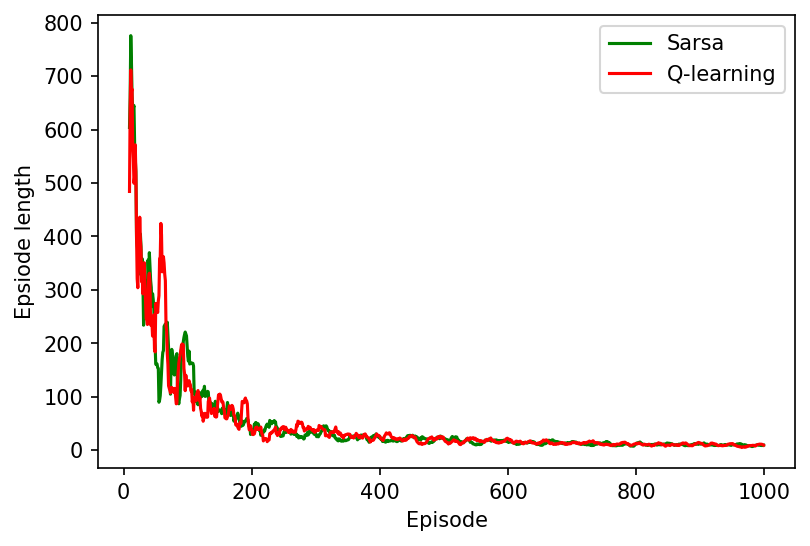

In [34]:
fig, ax = plt.subplots(dpi=150)

ma_q = pd.Series(ts_q).rolling(10).mean() # Moving average

ax.plot(ma_sarsa, label='Sarsa', color='green')
ax.plot(ma_q, label='Q-learning', color='red')
ax.set_xlabel('Episode')
ax.set_ylabel('Epsiode length')

plt.legend()